# 颜色空间的转换-RGB和LAB

## 1.原理

RGB无法直接转换成LAB，需要先转换成XYZ再转换成LAB，即：RGB——XYZ——LAB

因此转换公式分两部分：
（1）RGB转XYZ
假设r,g,b为像素三个通道，取值范围均为[0,255]，转换公式如下：

![](doc_imgs/22.png)
![](doc_imgs/23.png)
![](doc_imgs/24.png)

M=

0.4124,0.3576,0.1805

0.2126,0.7152,0.0722

0.0193,0.1192,0.9505

等同于如下公式：

X = var_R * 0.4124 + var_G * 0.3576 + var_B * 0.1805

Y = var_R * 0.2126 + var_G * 0.7152 + var_B * 0.0722

Z = var_R * 0.0193 + var_G * 0.1192 + var_B * 0.9505

上面的gamma函数，是用来对图象进行非线性色调编辑的，目的是提高图像对比度。这个函数不是唯一的，但是我在网上查到的基本都使用上式。

（2）XYZ转LAB

![](doc_imgs/25.png)
![](doc_imgs/26.png)

上面两个公式中，L*，a*，b*是最终的LAB色彩空间三个通道的值。X，Y，Z是RGB转XYZ后计算出来的值，Xn，Yn，Zn一般默认是95.047，100.0，108.883。

代码实现：

In [16]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pyexcel_xls import get_data
import pandas as pd
from pandas import DataFrame
import math

In [2]:
src = cv2.cvtColor(cv2.imread('../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [10]:
def rgb2lab_pixel(inputColor):
	RGB=[0,0,0]
	for i in range(0,len(inputColor)):
		RGB[i]=inputColor[i]/255.0

	X=RGB[0]*0.4124+RGB[1]*0.3576+RGB[2]*0.1805
	Y=RGB[0]*0.2126+RGB[1]*0.7152+RGB[2]*0.0722
	Z=RGB[0]*0.0193+RGB[1]*0.1192+RGB[2]*0.9505
	XYZ=[X,Y,Z]
	XYZ[0]/=95.045/100
	XYZ[1]/=100.0/100
	XYZ[2]/=108.875/100

	L=0
	for i in range(0,3):
		v=XYZ[i]
		if v>0.008856:
			v=pow(v,1.0/3)
			if i==1:
				L=116.0*v-16.0
		else:
			v*=7.787
			v+=16.0/116
			if i==1:
				L=903.3*XYZ[i]
		XYZ[i]=v

	a=500.0*(XYZ[0]-XYZ[1])
	b=200.0*(XYZ[1]-XYZ[2])
	Lab=[int(L),int(a),int(b)]
	return Lab

def rgb2lab(src):
    rows,cols = src.shape[0],src.shape[1]
    dst = np.zeros_like(src)
    for i in range(rows):
        for j in range(cols):
            rgb = src[i,j]
            lab = rgb2lab_pixel(rgb)
            dst[i,j] = lab
            
    return dst

In [14]:
def lab2rgb_pixel(inputColor):
	L=inputColor[0]
	a=inputColor[1]
	b=inputColor[2]
	#d=6.0/29
	T1=0.008856
	T2=0.206893
	d=T2
	fy =math.pow( (L + 16) / 116.0,3)
	fx = fy + a / 500.0
	fz = fy - b / 200.0
	#Y = fy > d ? fy * fy * fy : (fy - 16.0 / 116) * 3 * d * d
	fy = (fy) if (fy > T1) else ( L/903.3)
	Y=fy
	fy=(math.pow(fy,1.0/3)) if (fy > T1) else (7.787*fy+16.0/116)  # calculate XYZ[1], XYZ[0]=a/500.0+XYZ[1]

	# compute original XYZ[0]
	fx=fy+a/500.0
	X=(math.pow(fx,3.0)) if (fx > T2) else ((fx-16.0/116)/7.787)  # v^3>T1, so v>T1^(1/3)=

	# compute original XYZ[2]
	fz=fy-b/200.0
	Z=(math.pow(fz,3.0)) if (fz >T2) else ((fz-16.0/116)/7.787)

	X*=0.95045
	Z*=1.08875
	R = 3.240479 * X + (-1.537150) * Y + (-0.498535) * Z
	G = (-0.969256) * X + 1.875992 * Y + 0.041556 * Z
	B = 0.055648 * X + (-0.204043) * Y + 1.057311 * Z
	#R = max(min(R,1),0)
	#G = max(min(G,1),0)
	#B = max(min(B,1),0)
	RGB = [R, G, B];
	for i in range(0,3):
		RGB[i] = min(int(round(RGB[i] * 255)),255)
		RGB[i] = max(RGB[i],0)
	return RGB

def lab2rgb(lab):
    rows,cols = lab.shape[0],lab.shape[1]
    dst = np.zeros_like(lab)
    for i in range(rows):
        for j in range(cols):
            lab = src[i,j]
            rgb = lab2rgb_pixel(lab)
            dst[i,j] = rgb
            
    return dst

Text(0.5,1,'RGB->LAB')

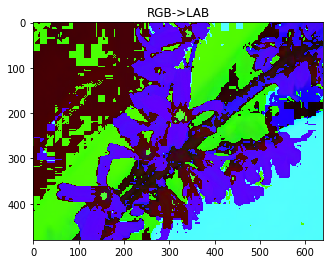

In [12]:
lab = rgb2lab(src)
plt.imshow(lab)
plt.title('RGB->LAB')

Text(0.5,1,'LAB->RGB')

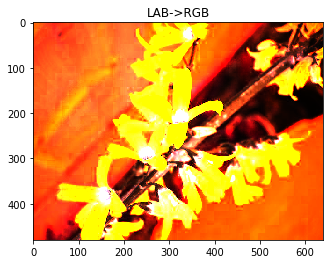

In [21]:
rgb = lab2rgb(lab)
plt.imshow(cv2.convertScaleAbs(rgb))
plt.title('LAB->RGB')

In [20]:
print(rgb.dtype)

uint8


In [23]:
def rgb2lab_matrix(colors):
	shape = colors.shape
	rgb = np.reshape(colors,(shape[0] * shape[1],shape[2]))
# 	n=len(colors)
	n = len(rgb)
	colors = np.array(rgb)
# 	colors=np.array(colors)
	colors=colors.astype('float')
	RGBs=colors/255.0 
	Xs=RGBs[:,0]*0.4124+RGBs[:,1]*0.3576+RGBs[:,2]*0.1805
	Ys=RGBs[:,0]*0.2126+RGBs[:,1]*0.7152+RGBs[:,2]*0.0722
	Zs=RGBs[:,0]*0.0193+RGBs[:,1]*0.1192+RGBs[:,2]*0.9505
	XYZs=np.vstack((Xs,Ys,Zs)).transpose()  
	
	XYZs[:,0]=XYZs[:,0]/(95.045/100.0)
	XYZs[:,1]=XYZs[:,1]/(100.0/100.0)
	XYZs[:,2]=XYZs[:,2]/(108.875/100.0)
	L=np.zeros((n,3),dtype='float')
	for i in range(0,3):
		v=XYZs[:,i]
		vv=np.where(v>0.008856,v**(1.0/3),v*7.787+16.0/116)
		L[:,i]=np.where(v>0.008856,116.0*vv-16.0,v*903.3)
		XYZs[:,i]=vv

	As=500.0*(XYZs[:,0]-XYZs[:,1])
	Bs=200.0*(XYZs[:,1]-XYZs[:,2])
	Ls=L[:,1]
	LABs=np.vstack((Ls,As,Bs)).transpose()
	LABs=np.reshape(LABs.astype('int'),shape)
	return LABs


In [24]:
def lab2rgb_matrix(colors):
	shape = colors.shape
	rgb = np.reshape(colors,(shape[0] * shape[1],shape[2]))
	n=len(rgb)
	colors=np.array(rgb)
	Ls=colors[:,0]
	As=colors[:,1]
	Bs=colors[:,2]
	T1=0.008856
	T2=0.206893
	d=T2
	fys=((Ls+16)/116.0)**3.0
	fxs=fys+As/500.0
	fzs=fys-Bs/200.0
	Xs=np.zeros((n),dtype='float')
	Ys=np.zeros((n),dtype='float')
	Zs=np.zeros((n),dtype='float')

	fys=np.where(fys>T1,fys,Ls/903.3)
	Ys=fys
	fys=np.where(fys>T1,fys**(1.0/3),fys*7.787+16.0/116)

	fxs=fys+As/500.0
	Xs=np.where(fxs>T2,fxs**3.0,(fxs-16.0/116)/7.787)

	fzs=fys-Bs/200.0
	Zs=np.where(fzs>T2,fzs**3.0,(fzs-16.0/116)/7.787) 

	Xs*=0.95045
	Zs*=1.08875
	Rs = 3.240479 * Xs + (-1.537150) * Ys + (-0.498535) * Zs
	Gs = (-0.969256) * Xs + 1.875992 * Ys + 0.041556 * Zs
	Bs = 0.055648 * Xs + (-0.204043) * Ys + 1.057311 * Zs
	RGBs=np.vstack((Rs,Gs,Bs)).transpose() 
	RGBs=np.maximum(RGBs*255,0.0)
	RGBs=np.minimum(RGBs,255.0)
	RGBs=np.reshape(RGBs.astype('int'),shape)
	return RGBs

Text(0.5,1,'RGB->LAB')

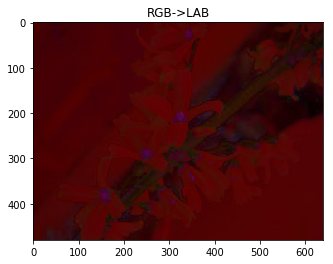

In [33]:
lab = rgb2lab_matrix(src)
plt.imshow(cv2.convertScaleAbs(lab))
plt.title('RGB->LAB')

Text(0.5,1,'LAB->RGB')

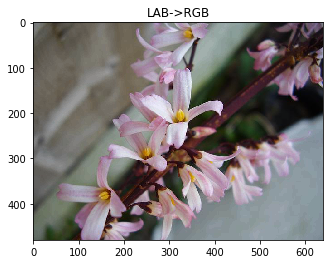

In [36]:
rgb = lab2rgb_matrix(lab)
plt.imshow(rgb)
plt.title('LAB->RGB')

调用OpenCV实现

Text(0.5,1,'OpenCV:RGB->LAB')

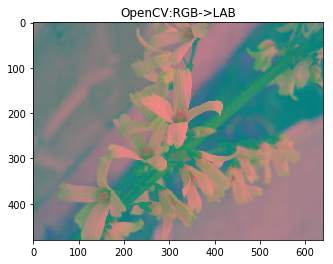

In [28]:
lab = cv2.cvtColor(src,cv2.COLOR_BGR2LAB)
plt.imshow(lab)
plt.title('OpenCV:RGB->LAB')

Text(0.5,1,'OpenCV:LAB->RGB')

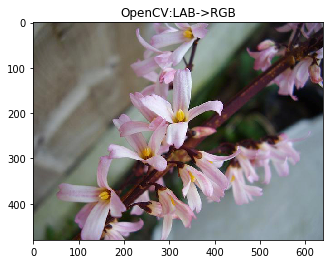

In [29]:
rgb = cv2.cvtColor(lab,cv2.COLOR_LAB2BGR)
plt.imshow(rgb)
plt.title('OpenCV:LAB->RGB')

参考：

[1].https://www.cnblogs.com/hrlnw/p/4126017.html